In [1]:
import numpy as np
import pandas as pd
import sklearn
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
import tensorflow as tf


In [2]:
# 预处理输入数据
def preprocessing(nmp_df,power_df):
    nmp_df.head(10)
    power_df.head(10)
    fix_df=pd.merge(nmp_df, power_df, on=['Datetime'], how='left')
    fix_df.head(10)
    fix_df.describe()

    return fix_df

In [3]:
# 读取数据
his_nmp_fd_df = pd.read_csv('.\\data\\FD001\\03 His_NWP_FD.csv',parse_dates=["Datetime"],index_col=[0])
his_power_fd_df = pd.read_csv('.\\data\\FD001\\02_His_Power_FD.csv',parse_dates=["Datetime"],index_col=[0])
his_fd_df=preprocessing(his_nmp_fd_df,his_power_fd_df)
his_fd_df.to_csv('his_df.csv',encoding = 'utf-8') #存储合并后数据

In [4]:
df=pd.read_csv('his_df.csv',parse_dates=["Datetime"],index_col=[0])
df.head()

,Speed10,Direction10,Speed30,Direction30,Speed50,Direction50,Speed70,Direction70,Speed90,Direction90,Speed100,Direction100,Temper,Pressure,Humidity,Power(MW)
Datetime,,,,,,,,,,,,,,,,
2022-07-15 00:00:00,3.3696,290.3172,4.1829,295.0334,4.9253,297.9698,5.6139,300.0360,6.2446,301.5774,6.5423,302.1353,27.59,1003.96,93.20,0.0216
2022-07-15 00:15:00,3.3092,291.4477,4.1100,296.1286,4.8389,299.0546,5.5137,301.1241,6.1388,302.6287,6.4347,303.2702,27.61,1004.37,93.05,0.0218
2022-07-15 00:30:00,3.4671,295.0868,4.2669,299.3285,5.0000,302.0054,5.6718,303.8582,6.2926,305.2307,6.5832,305.7906,27.62,1004.25,92.96,0.4021
2022-07-15 00:45:00,3.6896,296.9123,4.4933,300.7888,5.2253,303.4468,5.9067,305.1430,6.5341,306.5367,6.8241,307.1386,27.62,1003.96,92.82,0.5867
2022-07-15 01:00:00,3.7095,298.4995,4.5220,302.3546,5.2791,304.8942,5.9740,306.6973,6.6113,307.9966,6.9170,308.5434,27.64,1003.68,92.59,0.3889


In [5]:
df.tail()

,Speed10,Direction10,Speed30,Direction30,Speed50,Direction50,Speed70,Direction70,Speed90,Direction90,Speed100,Direction100,Temper,Pressure,Humidity,Power(MW)
Datetime,,,,,,,,,,,,,,,,
2022-07-21 22:45:00,4.5521,307.3230,6.1812,312.0492,7.6793,314.6835,8.4867,316.0503,8.6879,316.8657,8.7815,317.1689,27.90,1009.53,87.03,2.3584
2022-07-21 23:00:00,4.5931,308.9910,5.4076,312.4519,6.1518,314.8683,6.7197,316.4472,6.8998,317.2906,6.9864,317.6105,27.92,1010.14,0.00,2.8011
2022-07-21 23:15:00,3.3338,303.4994,4.6673,310.4815,5.9120,314.1776,6.7329,316.0832,6.9197,316.9911,7.0061,317.3137,27.44,1009.89,0.00,3.6597
2022-07-21 23:30:00,3.2299,299.8989,4.5556,308.4045,5.8027,312.7652,6.6115,314.9387,6.7961,315.8942,6.8890,316.2939,27.46,1009.84,0.00,3.4466
2022-07-21 23:45:00,3.4215,297.3140,4.7503,306.2668,6.0103,311.0873,6.7556,313.3806,6.9372,314.3576,7.0216,314.8269,27.46,1009.69,0.00,3.0725


In [6]:
df.shape

(672, 16)

In [7]:
# 划分train valid test集
fd_df_train = df[:int(0.6*len(df))]
fd_df_valid = df[int(0.6*len(df)):int(0.8*len(df))]
fd_df_test =df[int(0.8*len(df)):]

In [8]:
# # 划分train valid test集
# fd_df_train = df[:int(0.6*len(df))]
# fd_df_valid = df[int(0.6*len(df)):]
# fd_df_test =df[int(0.8*len(df)):]

In [9]:
# 对数据进行归一化处理
scaler = MinMaxScaler(feature_range=(0,1))
scaler = scaler.fit(df)
df_for_training_scaled = scaler.transform(fd_df_train)
df_for_validing_scaled=scaler.transform(fd_df_valid)
df_for_testing_scaled=scaler.transform(fd_df_test)

In [10]:
# 分离x与y
def createXY(array, days_used_to_train=7):
    features = list()
    labels = list()

    for i in range(days_used_to_train, len(array)):
        features.append(array[i-days_used_to_train:i, :])
        labels.append(array[i, -1])
    return np.array(features), np.array(labels)

train_X,train_y=createXY(df_for_training_scaled)
valid_X,valid_y=createXY(df_for_validing_scaled)
test_X,test_y=createXY(df_for_testing_scaled)

In [11]:
df_X,df_y=createXY(np.array(df))

In [12]:
train_X.shape

(396, 7, 16)

In [13]:
train_y.shape

(396,)

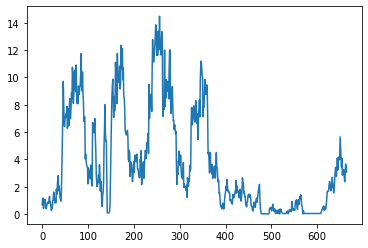

In [14]:
plt.plot(range(len(df_y)), df_y, label='history')

In [15]:
def build_model(optimizer,size):
    tf.random.set_seed(1) #设置随机数种子
    # Create grid_model
    grid_model = tf.keras.Sequential()
    grid_model.add(tf.keras.layers.LSTM(units=64))
    grid_model.add(tf.keras.layers.Dense(64))
    grid_model.add(tf.keras.layers.Dense(size))
    grid_model.add(tf.keras.layers.Dense(1))

    # Compile the grid_model
    grid_model.compile(
    optimizer='adam',
    loss='mse')

    return grid_model

In [16]:
from keras.wrappers.scikit_learn import KerasClassifier
grid_model = KerasRegressor(build_fn=build_model)

C:\Users\23966\AppData\Local\Temp\ipykernel_2776\560159353.py:2: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  grid_model = KerasRegressor(build_fn=build_model)


In [17]:
def easy_doing(begin,end,step):
    value=[]
    i=begin
    for i in np.arange(begin, end, step):
        value.append(i)
    return value

In [18]:
parameters = {'batch_size' : [32,16,24],'epochs' : [40],'optimizer' : ['adam'],'size' : [32]}

In [19]:
grid_search = GridSearchCV(estimator = grid_model,
                          param_grid = parameters,
                          scoring=None,
                          cv = 2)

In [20]:
grid_search = grid_search.fit(train_X, train_y,
    validation_data=(valid_X, valid_y))

Epoch 1/40
7/7 [==============================] - 2s 70ms/step - loss: 0.1602 - val_loss: 0.4284
Epoch 2/40
7/7 [==============================] - 0s 8ms/step - loss: 0.0335 - val_loss: 0.0137
Epoch 3/40
7/7 [==============================] - 0s 8ms/step - loss: 0.0355 - val_loss: 0.0376
Epoch 4/40
7/7 [==============================] - 0s 8ms/step - loss: 0.0178 - val_loss: 0.0782
Epoch 5/40
7/7 [==============================] - 0s 8ms/step - loss: 0.0167 - val_loss: 0.0331
Epoch 6/40
7/7 [==============================] - 0s 8ms/step - loss: 0.0137 - val_loss: 0.0303
Epoch 7/40
7/7 [==============================] - 0s 8ms/step - loss: 0.0117 - val_loss: 0.0138
Epoch 8/40
7/7 [==============================] - 0s 8ms/step - loss: 0.0101 - val_loss: 0.0101
Epoch 9/40
7/7 [==============================] - 0s 8ms/step - loss: 0.0090 - val_loss: 0.0066
Epoch 10/40
7/7 [==============================] - 0s 8ms/step - loss: 0.0081 - val_loss: 0.0047
Epoch 11/40
7/7 [=====================

13/13 [==============================] - 0s 6ms/step - loss: 0.0127 - val_loss: 0.0242
Epoch 5/40
13/13 [==============================] - 0s 6ms/step - loss: 0.0109 - val_loss: 0.0121
Epoch 6/40
13/13 [==============================] - 0s 6ms/step - loss: 0.0090 - val_loss: 0.0054
Epoch 7/40
13/13 [==============================] - 0s 6ms/step - loss: 0.0076 - val_loss: 0.0021
Epoch 8/40
13/13 [==============================] - 0s 6ms/step - loss: 0.0079 - val_loss: 0.0054
Epoch 9/40
13/13 [==============================] - 0s 6ms/step - loss: 0.0073 - val_loss: 0.0023
Epoch 10/40
13/13 [==============================] - 0s 6ms/step - loss: 0.0074 - val_loss: 0.0018
Epoch 11/40
13/13 [==============================] - 0s 6ms/step - loss: 0.0076 - val_loss: 0.0022
Epoch 12/40
13/13 [==============================] - 0s 6ms/step - loss: 0.0072 - val_loss: 0.0038
Epoch 13/40
13/13 [==============================] - 0s 6ms/step - loss: 0.0067 - val_loss: 0.0026
Epoch 14/40
13/13 [========

Epoch 6/40
9/9 [==============================] - 0s 7ms/step - loss: 0.0115 - val_loss: 0.0108
Epoch 7/40
9/9 [==============================] - 0s 7ms/step - loss: 0.0090 - val_loss: 0.0108
Epoch 8/40
9/9 [==============================] - 0s 7ms/step - loss: 0.0087 - val_loss: 0.0028
Epoch 9/40
9/9 [==============================] - 0s 7ms/step - loss: 0.0077 - val_loss: 0.0016
Epoch 10/40
9/9 [==============================] - 0s 8ms/step - loss: 0.0076 - val_loss: 0.0030
Epoch 11/40
9/9 [==============================] - 0s 7ms/step - loss: 0.0073 - val_loss: 0.0013
Epoch 12/40
9/9 [==============================] - 0s 7ms/step - loss: 0.0072 - val_loss: 0.0037
Epoch 13/40
9/9 [==============================] - 0s 7ms/step - loss: 0.0071 - val_loss: 0.0015
Epoch 14/40
9/9 [==============================] - 0s 7ms/step - loss: 0.0080 - val_loss: 0.0038
Epoch 15/40
9/9 [==============================] - 0s 7ms/step - loss: 0.0074 - val_loss: 0.0046
Epoch 16/40
9/9 [=================

13/13 [==============================] - 0s 5ms/step - loss: 0.0097 - val_loss: 0.0026
Epoch 10/40
13/13 [==============================] - 0s 5ms/step - loss: 0.0095 - val_loss: 0.0032
Epoch 11/40
13/13 [==============================] - 0s 5ms/step - loss: 0.0090 - val_loss: 0.0019
Epoch 12/40
13/13 [==============================] - 0s 5ms/step - loss: 0.0092 - val_loss: 0.0027
Epoch 13/40
13/13 [==============================] - 0s 5ms/step - loss: 0.0086 - val_loss: 0.0021
Epoch 14/40
13/13 [==============================] - 0s 5ms/step - loss: 0.0088 - val_loss: 0.0069
Epoch 15/40
13/13 [==============================] - 0s 5ms/step - loss: 0.0088 - val_loss: 0.0021
Epoch 16/40
13/13 [==============================] - 0s 6ms/step - loss: 0.0081 - val_loss: 0.0016
Epoch 17/40
13/13 [==============================] - 0s 6ms/step - loss: 0.0084 - val_loss: 0.0016
Epoch 18/40
13/13 [==============================] - 0s 6ms/step - loss: 0.0081 - val_loss: 0.0063
Epoch 19/40
13/13 [===

In [21]:
# 显示最佳模型参数
grid_search.best_params_

{'batch_size': 32, 'epochs': 40, 'optimizer': 'adam', 'size': 32}

In [22]:
# 输出最佳模型为my_model
my_model=grid_search.best_estimator_.model
my_model

4/4 [==============================] - 0s 5ms/step


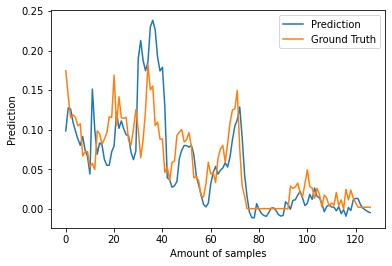

In [23]:
# 查看valid集预测结果
pred_valid_y = my_model.predict(valid_X)
plt.plot(range(len(pred_valid_y)), pred_valid_y, label='Prediction')
plt.plot(range(len(pred_valid_y)), valid_y, label='Ground Truth')
plt.xlabel('Amount of samples')
plt.ylabel('Prediction')
plt.legend()
plt.show()

In [24]:
# %%
# Predicting
pred_y = my_model.predict(test_X)


4/4 [==============================] - 0s 2ms/step


In [25]:
pred_y.shape

(128, 1)

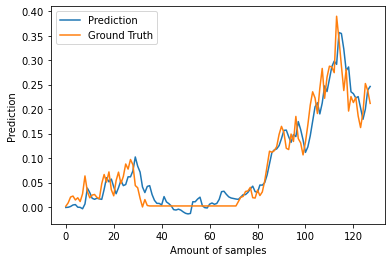

In [26]:
# %% Plotting
plt.plot(range(len(pred_y)), pred_y, label='Prediction')
plt.plot(range(len(pred_y)), test_y, label='Ground Truth')
plt.xlabel('Amount of samples')
plt.ylabel('Prediction')
plt.legend()
plt.show()
# %%

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step
[ 2.8670404e+00  1.5040177e+00  9.5373470e-01  7.1853763e-01
  6.6131330e-01  6.9611973e-01  7.5824201e-01  8.1975812e-01
  8.3926678e-01  1.1244178e+00  1.0935839e+00  1.0615069e+00
  1.0345522e+00  8.8130039e-01  8.5038149e-01  8.2920837e-01
  7.8101581e-01  7.4005735e-01  6.9806451e-01  6.7202163e-01
  6.5815592e-01  9.3371361e-01  9.3352473e-01  8.6434972e-01
  7.9049212e-01  5.7470083e-01  5.0706923e-01  4.5521623e-01
  4.0304059e-01  3.6605212e-01  3.5040343e-01  3.5454974e-01
  3.7897050e-01  7.6663405e-01  8.8424039e-01  8.7063581e-01
  8.6576992e-01  7.7265894e-01  8.0227238e-01  8.5144210e-01
  8.5125178e-01  8.6997217e-01  8.9003277e-01  9.0538239e-01
  9.2273808e-01  1.0660349e+00  1.0613494e+00  1.0039219e+00
  9.7368580e-01  1.0006249e+00  1.0337889e+00  1.0363138e+00
  1.0079827e+00  9.8981273e-01  9.9384898e-01  1.0145166e+00
  1.0325900e+00  1.1389204e+00  1.1114156e+00  1.0797578e+00
  1.0337106e+00  1.0854613e+00  1

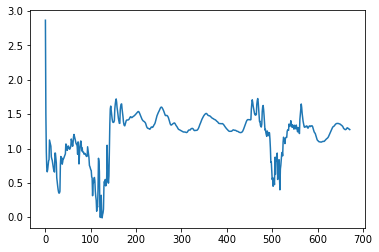

In [43]:
# prediction of feature
df_30_days_past=df.iloc[-7:,:]
df_30_days_past.tail()
df_30_days_future=pd.read_csv('.\\data\\FD001\\04 Fore_NWP_FD.csv',parse_dates=["Datetime"],index_col=[0])
df_30_days_future
df_30_days_future.shape
df_30_days_future["Power(MW)"]=0
df_30_days_future=df_30_days_future[["Speed10" , "Direction10" , "Speed30" , "Direction30" , "Speed50" , "Direction50" , "Speed70" , "Direction70" , "Speed90" , "Direction90" , "Speed100" , "Direction100" , "Temper" , "Pressure" , "Humidity" , "Power(MW)"]]
old_scaled_array=scaler.transform(df_30_days_past)
new_scaled_array=scaler.transform(df_30_days_future)
new_scaled_df=pd.DataFrame(new_scaled_array)
new_scaled_df.iloc[:,0]=np.nan
full_df=pd.concat([pd.DataFrame(old_scaled_array),new_scaled_df]).reset_index().drop(["index"],axis=1)
full_df_scaled_array=full_df.values
all_data=[]
time_step=7
for i in range(time_step,len(full_df_scaled_array)):
  data_x=[]
  data_x.append(
    full_df_scaled_array[i-time_step :i , 0:full_df_scaled_array.shape[1]])
  data_x=np.array(data_x)
  prediction=my_model.predict(data_x)
  all_data.append(prediction)
  full_df.iloc[i,0]=prediction
new_array=np.array(all_data)
new_array=new_array.reshape(-1,1)
prediction_copies_array = np.repeat(new_array,16, axis=-1)
y_pred_future_30_days = scaler.inverse_transform(np.reshape(prediction_copies_array,(len(new_array),16)))[:,0]
print(y_pred_future_30_days)
plt.plot(range(len(y_pred_future_30_days)), y_pred_future_30_days, label='Prediction')

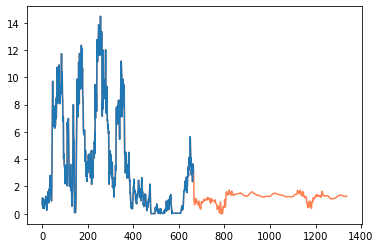

In [45]:
#绘制整体发电量图
total = np.hstack((df_y,y_pred_future_30_days))
plt.plot(range(len(total)), total, label='Prediction',color='coral')
plt.plot(range(len(df_y)), df_y, label='Prediction')

In [29]:
# # prediction of feature
# df_30_days_past=df.iloc[-7:,:]
# df_30_days_past.tail()

In [30]:
# df_30_days_future=pd.read_csv('.\\data\\FD001\\04 Fore_NWP_FD.csv',parse_dates=["Datetime"],index_col=[0])
# df_30_days_future
# df_30_days_future.shape

In [31]:
# df_30_days_future["Power(MW)"]=0

In [32]:
# df_30_days_future

In [33]:
# df_30_days_future=df_30_days_future[["Speed10" , "Direction10" , "Speed30" , "Direction30" , "Speed50" , "Direction50" , "Speed70" , "Direction70" , "Speed90" , "Direction90" , "Speed100" , "Direction100" , "Temper" , "Pressure" , "Humidity" , "Power(MW)"]]

In [34]:
# old_scaled_array=scaler.transform(df_30_days_past)

In [35]:
# old_scaled_array.shape

In [36]:
# new_scaled_array=scaler.transform(df_30_days_future)

In [37]:
# new_scaled_array.shape

In [38]:

# new_scaled_df=pd.DataFrame(new_scaled_array)
# new_scaled_df.iloc[:,0]=np.nan
# full_df=pd.concat([pd.DataFrame(old_scaled_array),new_scaled_df]).reset_index().drop(["index"],axis=1)

In [39]:
# full_df.shape

In [40]:
# full_df_scaled_array=full_df.values
# all_data=[]
# time_step=7
# for i in range(time_step,len(full_df_scaled_array)):
#   data_x=[]
#   data_x.append(
#     full_df_scaled_array[i-time_step :i , 0:full_df_scaled_array.shape[1]])
#   data_x=np.array(data_x)
#   prediction=grid_model.predict(data_x)
#   all_data.append(prediction)
#   full_df.iloc[i,0]=prediction

In [41]:
# new_array=np.array(all_data)
# new_array=new_array.reshape(-1,1)
# prediction_copies_array = np.repeat(new_array,16, axis=-1)
# y_pred_future_30_days = scaler.inverse_transform(np.reshape(prediction_copies_array,(len(new_array),16)))[:,0]
# print(y_pred_future_30_days)

In [42]:
# plt.plot(range(len(y_pred_future_30_days)), y_pred_future_30_days, label='Prediction')